In [1]:
%pylab inline
import torch

Populating the interactive namespace from numpy and matplotlib


In [49]:
import wandb
import inspect
import seaborn as sns
import pandas as pd
import json
from tqdm.notebook import tqdm
import os
import yaml


class ResultsManager:
    def __init__(self, wandb_user, wandb_project, algorithm_info_file, dataset_info_file, sid_info_file, verbose=False):
        self.api = wandb.Api()
        self.verbose = verbose
        self.wandb_user = wandb_user
        self.wandb_project = wandb_project
        
        with open(dataset_info_file, 'r') as stream:
            self.datasets_info = yaml.safe_load(stream)
    
        with open(sid_info_file,'r') as stream:
            self.sid_info = yaml.safe_load(stream)

        with open(algorithm_info_file,'r') as stream:
            self.algorithms_info = yaml.safe_load(stream)
        
        if verbose:
            print('User: %s' % wandb_user)
            print('Project: %s' % wandb_project)
            print('Algorithms: %s' % str(list(self.algorithms_info.keys())))
            print('Datasets: %s' % str(list(self.datasets_info.keys())))
            
    def sid2sweep(self, sid):
        return self.api.sweep('%s/%s'%(self.wandb_project, sid))
    
    def get_name(self, idx):
        if idx in self.datasets_info:
            return self.datasets_info[idx]['name']
        elif idx in self.algorithms_info:
            return self.algorithms_info[idx]['name']
        else:
            raise Exception('%s name not found')
            
    def datalg2uid(self, dataset, algorithm):
        return dataset+'-'+algorithm
    
    def sid2datalg(self, sid):
        uids = [uid for uid in self.sid_info if self.sid_info[uid]['id'] == sid]
        assert len(uids) == 1
        return self.uid2datalg(uids[0])

    def uid2datalg(self, uid):
        datalg = uid.split('-')
        return datalg[0], datalg[1]

    def get_sweep(self, dataset, algorithm):
        name = self.datalg2uid(dataset, algorithm)
        sid = self.sid_info[name]['id']
        return self.sid2sweep(sid)
    
    def get_algorithms(self, dataset=None):
        if dataset:
            return [alg for alg in self.algorithms_info.keys() 
                    if self.datalg2uid(dataset,alg) in self.sid_info]
        else:
            return [alg for alg in self.algorithms_info.keys()]
        
    def get_run_config(self, run):
        dataset, algorithm = self.sid2datalg(run.sweep.id)
        key_lookup = self.algorithms_info[algorithm]['params']
        return {key: run.config[value['config_key']] for key,value in key_lookup.items()}
    

if 'WANDB_USER' in os.environ:
    wandb_user = os.environ['WANDB_USER']
else:
    raise Exception('Please set WANDB_USER')
    
if 'WANDB_PROJECT' in os.environ:
    wandb_project = os.environ['WANDB_PROJECT']
else:
    raise Exception('Please set WANDB_PROJECT')

    
rm = ResultsManager(wandb_user=wandb_user, 
                    wandb_project=wandb_project, 
                    algorithm_info_file='results/algorithms.yml', 
                    dataset_info_file='results/datasets.yml', 
                    sid_info_file='results/ids.yml', 
                    verbose=True)


User: mfederici
Project: causal-mib
Algorithms: ['ECI', 'EI', 'VREx', 'VIB', 'IRM']
Datasets: ['D_CMNIST', 'D_CMNIST_v2']


In [50]:
def decorate_plot(config, ax):
    for name, point in config['plot'].items():
        ax.plot(point['coord'][0], point['coord'][1], label='$%s$'%name, **point['params'])  

    ax.set_xlim(*config['lims']['x'])
    ax.set_ylim(*config['lims']['y'])

    ax.set_xlabel('$\\mathbb{E}_{train}[-\\log\\ q_\\theta(y|x)]$', size=15)
    ax.set_ylabel('$\\mathbb{E}_{test}[-\\log\\ q_\\theta(y|x)]$', size=15)
    

In [53]:
def get_last_mixed_data(run, consider_last=None, samples=None):
        if consider_last is None:
            h = run.history(samples=samples, pandas=False)
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':(r['test_ce_01']+r['test_ce_02'])/2.0, 
                        'test':r['test_ce_09'],
                        'step': r['_step']} for r in h if 'test_ce_01' in r]
        return pd.DataFrame(data)
    
def get_last_data(run, consider_last=None):
        if consider_last is None:
            h = run.scan_history()
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':r['train_ce'], 
                 'test':r['test_ce'],
                 'step': r['_step']} for r in h if 'test_ce' in r]
        return pd.DataFrame(data)
    
def sample_data(run, samples=None, consider_last=None):
    h = run.history(samples=samples, pandas=False)
        
    data = [{'train':r['train_ce'], 
             'test':r['test_ce'],
             'step': r['_step']} for r in h if 'test_ce' in r]
    return pd.DataFrame(data)

    
def _get_last_data(run, consider_last=None):
        if consider_last is None:
            h = run.scan_history()
        else:
            min_step = run.lastHistoryStep-consider_last
            h = run.scan_history(min_step=min_step)
        data = [{'train':r['CE(train_t0)'], 
                 'test':r['CE(test_t1)'],
                 'step': r['_step']} for r in h if 'CE(test_t1)' in r]
        return pd.DataFrame(data)
    
def _sample_data(run, samples=None, consider_last=None):
    h = run.history(samples=samples, pandas=False)
        
    data = [{'train':r['CE(train_t0)'], 
             'test':r['CE(test_t1)'],
             'step': r['_step']} for r in h if 'CE(test_t1)' in r]
    return pd.DataFrame(data)

process_run = {
    'D_CMNIST': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'D_CMNIST_v2': {
        'get_last': get_last_data,
        'get_all': get_last_data,
        'sample': sample_data
    },
    'CMNIST_v3': {
        'get_last': _get_last_data,
        'get_all': _get_last_data,
        'sample': _sample_data
    },
    'SpeechCommands': {
        'get_last': get_last_data,
        'get_all': get_last_data,
        'sample': sample_data,
    }
    
}

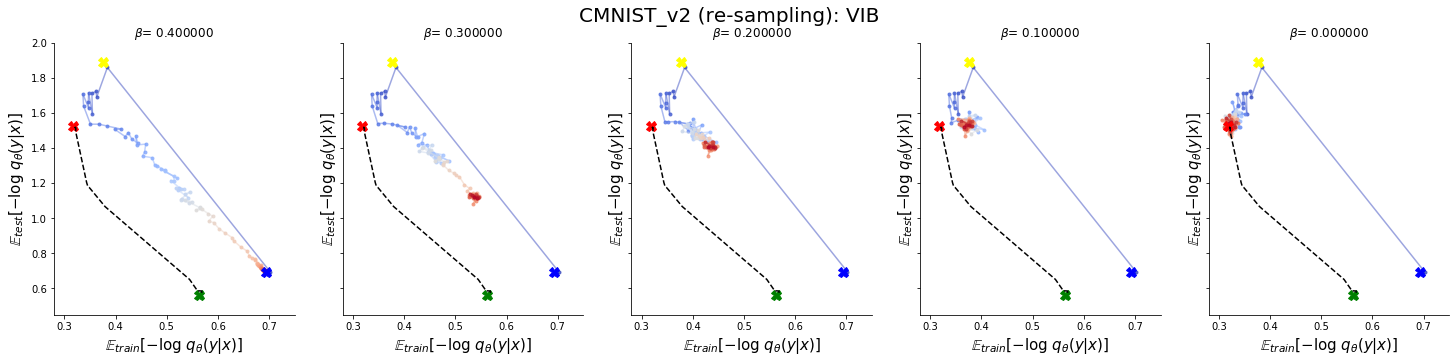

In [54]:
dataset = 'D_CMNIST_v2'
algorithm = 'VIB'

runs = rm.get_sweep(dataset=dataset, algorithm=algorithm).runs

cmap = plt.get_cmap('coolwarm')

f, ax = plt.subplots(1,len(runs), figsize=(5*len(runs),5), sharex=True, sharey=True)
if len(runs)==1:
    ax = [ax]

sns.despine()

f.suptitle('%s: %s'%(rm.get_name(dataset), rm.get_name(algorithm)), size=20)

for j,run in enumerate(tqdm(runs)):
    config_key = rm.algorithms_info[algorithm]['params']['beta']['config_key']
    ax[j].set_title('$\\beta$= %f'%(run.config[config_key]))
        
    run_data = process_run[dataset]['sample'](run,10000)
    colors = np.array([cmap(v/run_data['step'].values.max()) for v in run_data['step'].values[:len(run_data['step'].values)]])
    
    
    for i in range(len(colors)):
        ax[j].plot(run_data['train'][i], run_data['test'][i],'.',color=colors[i], alpha=0.8)
        ax[j].plot(run_data['train'][i:i+2], run_data['test'][i:i+2],'-',color=colors[i], alpha=0.5)
        
    decorate_plot(rm.datasets_info[dataset], ax[j])

        

        #ax[j].set_title(run_name, fontsize=20)

#ax[-1].legend(fontsize=12)

In [55]:


def plot_data(all_data, ax, color=None,uncertainty_alpha=0.5, label=None):
    points = []
    for data in all_data:
        mu = np.mean(data, axis=0)
        sigma = np.cov(data, rowvar=0)

        U, s, _ = numpy.linalg.svd(sigma)

        ax.plot(mu[0],mu[1],'.', color=color)
        ax.plot([mu[0]-U[0,0]*s[0]**0.5,mu[0]+U[0,0]*s[0]**0.5],[mu[1]-U[0,1]*s[0]**0.5,mu[1]+U[0,1]*s[0]**0.5],
                '-',color=color, alpha=uncertainty_alpha)
        ax.plot([mu[0]-U[1,0]*s[1]**0.5,mu[0]+U[1,0]*s[1]**0.5],[mu[1]-U[1,1]*s[1]**0.5,mu[1]+U[1,1]*s[1]**0.5],
                '-',color=color, alpha=uncertainty_alpha)
        points.append(mu.reshape(1,-1))
    points = np.concatenate(points,0)
    ax.plot(points[:,0], points[:,1], color=color, label=label)    
    
    
def plot_data_points(all_data, ax, color=None,uncertainty_alpha=0.5, label=None):
    all_data = pd.concat(all_data)
    
    x_min, x_max = all_data['train'].min(),all_data['train'].max()
    
    n = 3  # degree of polynomial
    p, C_p = np.polyfit(all_data['train'], all_data['test'], n, cov=True)  # C_z is estimated covariance matrix

    # Do the interpolation for plotting:
    t = np.linspace(x_min, x_max, 100)
    # Matrix with rows 1, t, t**2, ...:
    TT = np.vstack([t**(n-i) for i in range(n+1)]).T
    yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
    C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
    sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

    # Do the plotting:
    ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25, color=color) 
    ax.plot(t, yi,'-', color=color, label=label) 
    ax.plot(all_data['train'],all_data['test'],'.',color=color, alpha=0.1) 


def plot_sweep_result(runs, get_last_run_data, sortkey, ax, uncertainty_alpha=0.5, color=None, label=None, consider_last=1000):
    points = []
    reg_strenght = []
    all_data = [get_last_run_data(run, consider_last=consider_last) for run in runs]
    #sortby = [json.loads(run.json_config)[sortkey]['value'] for run in sweep.runs]
    #order = np.argsort(sortby)
    
    #print(order)
    if len(all_data)>0:
        plot_data_points(all_data, ax, color=color, uncertainty_alpha=uncertainty_alpha, label=label)



In [59]:
dataset = 'D_CMNIST_v2'
recompute = False
arch_filepath = 'definitions/architectures/CMNIST.py'
save_path = 'results/final_eval'

data_filepath = os.path.join(save_path,'%s.yml'%dataset)

from data import *
from eval.accuracy import AccuracyEvaluation, CrossEntropyEvaluation
from utils.run_manager.wandb import WANDBRunManager

datasets = {}

datasets['train_t0'] = DynamicCMNIST(path='datasets/MNIST', split='train+valid', 
                         cond_dist_file='data/cmnist_resources/%s_t0.pyt'%(dataset[2:]))
datasets['train_t1'] = DynamicCMNIST(path='datasets/MNIST', split='train+valid', 
                         cond_dist_file='data/cmnist_resources/%s_t1.pyt'%(dataset[2:]))
datasets['test_t0'] = DynamicCMNIST(path='datasets/MNIST', split='test', 
                         cond_dist_file='data/cmnist_resources/%s_t0.pyt'%(dataset[2:]))
datasets['test_t1'] = DynamicCMNIST(path='datasets/MNIST', split='test', 
                         cond_dist_file='data/cmnist_resources/%s_t1.pyt'%(dataset[2:]))

results = []
ids = []

if os.path.isfile(data_filepath):
    with open(data_filepath, 'r') as file:
        results = yaml.safe_load(file)
    ids = [row['rid'] for row in results]

for algorithm in rm.get_algorithms(dataset):
    sweep = rm.get_sweep(dataset, algorithm)
    print(algorithm)
    
    for run in tqdm(sweep.runs):
        if run.id in ids and not recompute:
            print('%s: already computed'%run.id)
            continue
        
        run_manager = WANDBRunManager(experiments_root='.', arch_filepath=arch_filepath, 
                                      desc=None, run_id=run.id, verbose=False, init=False)
        try:
            trainer, _ = run_manager.make_instances()
        except Exception as e:
            print(e)
            continue

        evaluators = {}
        for d in datasets:
            evaluators['CE(%s)'% d] = CrossEntropyEvaluation(trainer=trainer, datasets=datasets, evaluate_on=d)

        evaluation = {}
        for name, evaluator in tqdm(evaluators.items()):
            evaluation[name] = evaluator.evaluate()['value']

        evaluation['rid'] = run.id

        results.append(evaluation)


with open(data_filepath, 'w') as file:
    yaml.dump(results, file)
    
results = pd.DataFrame(results)

ECI


[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'

EI


[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'

VREx


[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'

VIB


[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'
[Errno 2] No such file or directory: 'data/cmnist_resources/CMNIST_v2_train.pyt'



In [ ]:
dataset = 'D_CMNIST'
arch_filepath = 'definitions/architectures/CMNIST.py'


data = []


for algorithm in rm.get_algorithms(dataset):
    sweep = rm.get_sweep(dataset, algorithm)
    print(algorithm)
    
    for run in tqdm(sweep.runs):
        config = rm.get_run_config(run)
        config['algorithm'] = rm.get_name(algorithm)
        config['rid']= run.id
        res = results[results['rid']==run.id].to_dict('records')
        if len(res)>0:
            config.update(res[0])
   
    
        data.append(config)
        
data = pd.DataFrame(data)

In [46]:
data[data['algorithm']=='VIB']

,beta,algorithm,rid,CE(test_t0),CE(test_t1),CE(train_t0),CE(train_t1),level_0
18,0.00,VIB,d3g03gt4,0.372686,1.337308,0.360584,1.351650,10
19,0.10,VIB,0t5zoiua,0.413536,1.342449,0.408903,1.349676,11
20,0.20,VIB,hepbswz2,0.466496,1.251951,0.474149,1.248592,12
21,0.25,VIB,3b6bckt1,0.527025,1.134309,0.520204,1.128690,13
22,0.30,VIB,its8jpcc,0.592260,0.956761,0.589110,0.956486,14
23,0.40,VIB,lvx9aj29,0.693376,0.693293,0.693244,0.693056,15


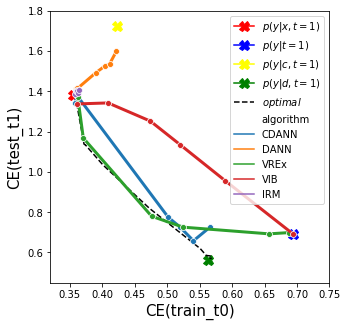

In [47]:
pd_data = pd.DataFrame(data)
f, ax = plt.subplots(1,1,figsize=(5,5))
decorate_plot(rm.datasets_info[dataset], ax)
sns.lineplot(data=pd_data, x='CE(train_t0)',y='CE(test_t1)', marker='o',linewidth=3, hue='algorithm')
ax.legend()

Data root: .


In [16]:
trainer, _ = run_manager.make_instances()

Instantiating class DynamicCMNIST from data with {'path': 'datasets/MNIST', 'split': 'train+valid', 'cond_dist_file': 'data/cmnist_resources/CMNIST_t0.pyt', 'data_root': '.'}
Instantiating class IRMTrainer from models
Instantiating Encoder with the parameters {'z_dim': 64, 'dist': 'Delta', 'dropout': 0.25, 'n_hidden': 128}
Instantiating LabelClassifier with the parameters {'z_dim': 64, 'dropout': 0, 'n_hidden': 128}
Instantiating class CrossEntropyEvaluation from eval
Instantiating class DynamicCMNIST from data with {'path': 'datasets/MNIST', 'split': 'test', 'cond_dist_file': 'data/cmnist_resources/CMNIST_t0.pyt', 'data_root': '.'}
Instantiating class CrossEntropyEvaluation from eval
Instantiating class DynamicCMNIST from data with {'path': 'datasets/MNIST', 'split': 'test', 'cond_dist_file': 'data/cmnist_resources/CMNIST_t1.pyt', 'data_root': '.'}
Instantiating class CrossEntropyEvaluation from eval
Instantiating class CrossEntropyEvaluation from eval
Instantiating class DynamicCMNIS

In [37]:
results = {}
for dataset, evaluator in tqdm(evaluators.items()):
    results[dataset] = {}
    results[evaluator.evaluate()['value']

In [38]:
results

{'train_t0': 0.3561955204669465,
 'train_t1': 1.3970472650325045,
 'test_t0': 0.36584293842315674,
 'test_t1': 1.400861096382141}

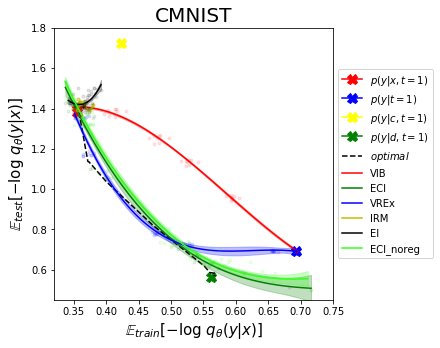

In [18]:

consider_last = 2000


datasets = [ 'D_CMNIST']
#datasets = ['SpeechCommands']

f, ax = plt.subplots(1,len(datasets),figsize=(5*len(datasets),5))
if len(datasets)==1:
    ax=[ax]

for i, dataset in enumerate(tqdm(datasets)):
    decorate_plot(t_results[dataset], ax[i])
    

    for sweep_name, sweep_data in tqdm(sweeps[dataset].items()):
        sweep = api.sweep('causal-mib/%s' % sweep_data['id'])
        
        select = None
        if 'select' in sweeps[dataset][sweep_name]:
            select = sweeps[dataset][sweep_name]['select']
            runs = [run for run in sweep.runs if run.config[select['name']] == select['value']]
        else:
            runs = sweep.runs
        
        plot_sweep_result(runs, process_run[dataset]['get_last'], 
                          sortkey=sweep_data['sortkey'], ax=ax[i],
                          
                          color=sweep_data['color'], 
                          label=sweep_name, consider_last=consider_last)


    ax[i].set_title(dataset, size=20)
ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


Text(0, 0.5, '$\\mathbb{E}_{test}[-\\log\\ q_\\theta(y|x)]$')

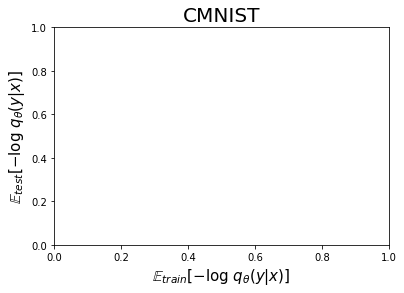

In [114]:
f, ax = plt.subplots(1,1)

ax.set_title('CMNIST', size=20)
ax.set_xlabel('$\\mathbb{E}_{train}[-\\log\\ q_\\theta(y|x)]$', size=15)
ax.set_ylabel('$\\mathbb{E}_{test}[-\\log\\ q_\\theta(y|x)]$', size=15)

In [18]:
from definitions.architectures.SpeechCommands import Encoder, LabelClassifier
import os

run = api.run('mfederici/causal-mib/jwaxtxsy')
checkpoint = 'model.pt'
download_dir = os.path.join('cache', checkpoint)

run.file(checkpoint).download(replace=True, root='cache')

encoder = Encoder(z_dim=64, dist='Delta', dropout=0.25, n_hidden=128)
classifier = LabelClassifier(z_dim=64, dropout=0, dist='Categorical', n_hidden=128)

state_dict = torch.load(download_dir, map_location=torch.device('cpu'))

In [24]:
labels = torch.ones(64).long().unsqueeze(1)
z = torch.zeros(64,64)

classifier(z).log_prob(labels.squeeze()).shape

torch.Size([64])

In [15]:
def get_pareto(points, n=100):
    alpha = np.linspace(0,np.pi/2,n)
    l = np.concatenate([np.cos(alpha).reshape(-1,1),np.sin(alpha).reshape(-1,1)],1)
    dist = np.abs(points @ l.T)
    min_dist_idx = np.argmin(dist, 0)
    return points[min_dist_idx,:]

In [36]:
points = np.random.normal(2,0.5,10000)
points = points.reshape(-1,2)

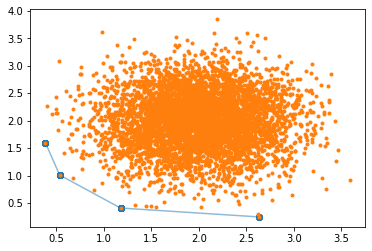

In [39]:

pareto = get_pareto(points, n=100)

plt.plot(pareto[:,0],pareto[:,1],'o-', alpha=0.5)
plt.plot(points[:,0],points[:,1],'.')


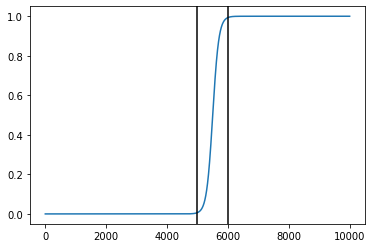

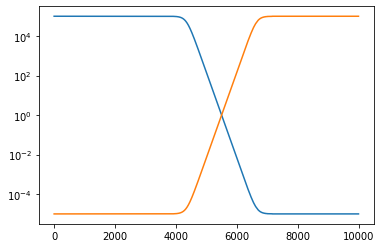

In [69]:
from torch import sigmoid

x = torch.FloatTensor(np.arange(0,10000))
scale = 1000
offset = 5000
start_value = 1e-5
end_value = 1-1e-5
s = scale/10

beta = start_value+sigmoid((x-offset-scale/2)/s)*(end_value-start_value)
plt.plot(x, beta)

plt.axvline(offset, color='k')
plt.axvline(offset+scale, color='k')
plt.show()

plt.plot(x, (1-beta)/beta)
plt.plot(x, beta/(1-beta))
plt.yscale('log')

In [74]:
iteration = 1

sigmoid(torch.FloatTensor([iteration])), 

(tensor([0.7311]), 0.7310585786300049)

In [17]:
run_data = run.scan_history()
last_beta = 1e-5

data = []

for row in run_data:
    if 'loss/beta' in row:
        beta = row['loss/beta']
        if beta==beta:
            last_beta = beta
    if 'test_ce_01' in row:
        if row['test_ce_01']==row['test_ce_01']:
            data.append({
                'beta':last_beta,
                'train_ce': 0.5*(row['test_ce_01']+row['test_ce_02']),
                'test_ce': row['test_ce_09']
            })

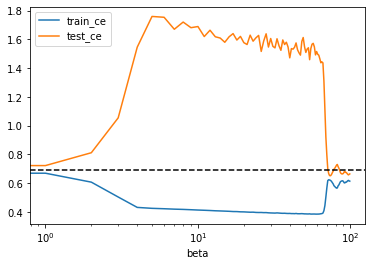

In [113]:
f, ax = plt.subplots(1,1)

pd.DataFrame(data).plot(x='beta',y='train_ce', ax=ax)
pd.DataFrame(data).plot(x='beta',y='test_ce', ax=ax)
ax.axhline(np.log(2), ls='--', color='k')
ax.set_xscale('log')

# Dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Loading the MNIST train and test set
train_set = MNIST('/data/MNIST', download=True, train=True, transform=ToTensor())
test_set = MNIST('/data/MNIST', download=True, train=False, transform=ToTensor())

In [3]:
from torchvision.transforms import Compose, RandomAffine, ToTensor
from utils.data import PixelCorruption

# Defining the augmentations
t = Compose([
    RandomAffine(degrees=15,
                 translate=[0.1, 0.1],
                 scale=[0.9, 1.1],
                 shear=15), # Small affine transformations
    ToTensor(),             # Conversion to torch tensor
    PixelCorruption(0.8)    # PixelCorruption with keep probability 80%
])

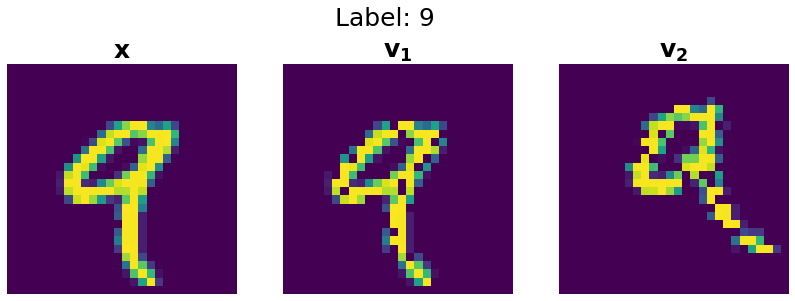

In [4]:
from utils.data import AugmentedDataset

# Creating the multi-view dataset
mv_train_set = AugmentedDataset(MNIST('/data/MNIST', train=True), t)

# Visualization original data and the two augmented views
f, ax = plt.subplots(1,3, figsize=(14,5))

idx = 4
v_1, v_2, y = mv_train_set[idx]
x, _ = train_set[idx]
f.suptitle('Label: %d'%y,size=25)

ax[0].set_title('$\\bf x$', size=25)
ax[0].imshow(x[0])

ax[1].set_title('$\\bf v_1$', size=25)
ax[1].imshow(v_1[0].data.numpy())

ax[2].set_title('$\\bf v_2$', size=25)
ax[2].imshow(v_2[0].data.numpy())


for a in ax:
    a.axis('off')

# Evaluation

In [5]:
from utils.evaluation import EmbeddedDataset
from utils.modules import Encoder
import os

# Encoder architecture
encoder = Encoder(z_dim = 64)

device = 'cuda' # Change to 'cpu' to perform the evaluation on CPU

encoder.eval()

Encoder(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=128, bias=True)
  )
)

VAE
-Embedding the dataset
-Computing classifier accuracy
InfoMax
-Embedding the dataset
-Computing classifier accuracy
MV-InfoMax
-Embedding the dataset
-Computing classifier accuracy
MIB
-Embedding the dataset
-Computing classifier accuracy


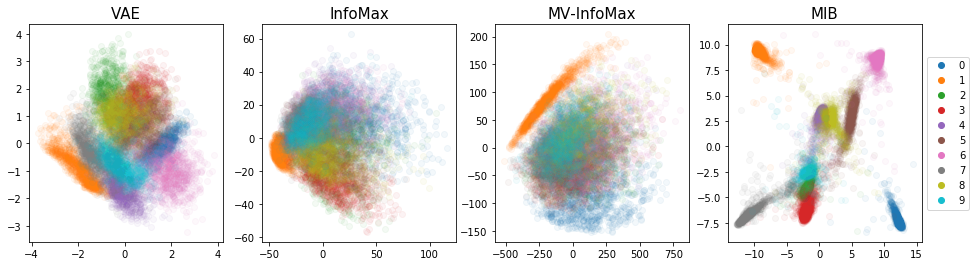

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from utils.evaluation import build_matrix

# Root containing the pre-trained models
model_path = 'trained_models'

# This comparison includes 
trained_models = [
    'VAE.pt',             # Beta Variational Autoencoder (Beta=4)
    'InfoMax.pt',         # InfoMax
    'MV-InfoMax.pt',      # Multi-View InfoMax
    'MIB.pt'              # Multi-View Information Bottleneck (Beta=1)
]
# The different models shown in this examples have been trained for a total of 1000 epochs

# Definition of axis and PCA for a qualitative visualization
f, ax = plt.subplots(1,len(trained_models),figsize=(len(trained_models) * 4, 4))
pca = PCA(n_components=2) 

# Definition of scaler and Logistic classifier used to evaluate the different representations
scaler = MinMaxScaler()
classifier = LogisticRegression(solver='saga', multi_class='multinomial', C=10, tol=.1)

# Each representation will be tested by training the logistic classifier on different
# number of given labels. In order to estimate the variance, each experiment
# will be performed 100 times on different balanced train sub-sets
repetitions = 100
examples_per_labels = [1, 2, 5, 10, 100, 1000]

accuracy_results = []

for i, model_file in enumerate(trained_models):    
    model_name = model_file.split('.')[0]
    print(model_name)
    
    # Load the parameters from a trained model
    state_dict = torch.load(os.path.join(model_path, model_file))['encoder']
    encoder.load_state_dict(state_dict)
    
    print('-Embedding the dataset')
        
    # Embed train and test set using the learned encoder
    embedded_train_set = EmbeddedDataset(base_dataset=train_set, encoder=encoder, device=device)
    embedded_test_set = EmbeddedDataset(base_dataset=test_set, encoder=encoder, device=device)
    
    # Convert the two sets into 2D matrices for evaluation
    X_train, Y_train = build_matrix(embedded_train_set)
    X_test, Y_test = build_matrix(embedded_test_set)
    
    # Project the test set on the principal components
    projected_X_test = pca.fit_transform(X_test)
    
    # And plot the representation with different colors corresponding to the different labels
    ax[i].set_title(model_name, size=15)
    for label in range(10):
        selected_X_test = projected_X_test[Y_test==label]
        ax[i].plot(selected_X_test[:,0], selected_X_test[:,1], 'o', label=label, alpha=0.05)
    
    print('-Computing classifier accuracy')
    
    # Scale train and test set
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Repeat multiple time to obtain a better estimation
    for i in range(repetitions):
        for examples_per_label in examples_per_labels:
            # Randomly select examples_per_label examples for each one of the 10 labels
            # to create a labeled training sub-set
            selected_ids = []
            for label in range(10):
                ids_with_label = np.arange(len(Y_train))[Y_train == label]
                selected_id = np.random.choice(ids_with_label, examples_per_label, replace=False)
                selected_ids.append(selected_id)
            selected_ids = np.concatenate(selected_ids)

            # Fit the linear classifier on the selection
            classifier.fit(X_train[selected_ids], Y_train[selected_ids])

            # Evaluate the classifier on the embedded test set
            test_accuracy = classifier.score(X_test, Y_test)

            accuracy_results.append({
                'Number of Labels': examples_per_label * 10,
                'Test Accuracy': test_accuracy,
                'Model': model_name
            })
    
    
# Add a legend to the last plot
leg = ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_marker('o')

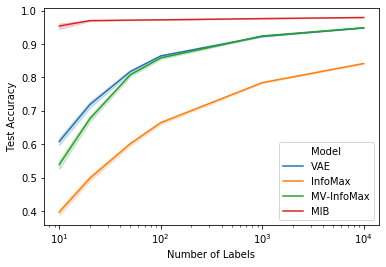

In [7]:
import pandas as pd
import seaborn as sns

# Visualize the accuracy of the classifier for different percentages of training labels
accuracy_results_df = pd.DataFrame(accuracy_results)

f, ax = plt.subplots(1,1)

sns.lineplot(data=accuracy_results_df, x='Number of Labels', y='Test Accuracy', hue='Model', ax=ax)
ax.set_xscale('log')